In [1]:
from domainbed import model_selection
from domainbed.scripts.collect_results import *
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import itertools
import os

In [42]:
d = {}
for root, dirs, files in os.walk("data/PACS", topdown=False):
    root = root.split('/')
    if len(root) == 4:
        d[root[-1]] = d.get(root[-1], []) + [len(files)]
y = {}
total = 0
for key in d:
    y[key] = np.sum(d[key])
    print(y[key])
    total += np.sum(d[key])

for key in y:
    y[key] = y[key]/total
    
for key in d:
    d[key] = np.array(d[key], dtype=float)/np.sum(d[key])

h = 0
for key in d:
    h -= (y[key] * d[key]) @ np.log(d[key])
    
print(-np.log(1/6))

1730
1446
1566
1113
943
1540
1654
1.791759469228055


In [55]:
d = {}
for root, dirs, files in os.walk("data/PACS", topdown=False):
    root = root.split('/')
    if len(root) == 4 and root[2] != 'photo':
        d[root[-1]] = d.get(root[-1], []) + [len(files)]
        
y = {}
total = 0
for key in d:
    y[key] = np.sum(d[key])
    print(y[key])
    total += np.sum(d[key])

for key in y:
    y[key] = y[key]/total
    
for key in d:
    d[key] = np.array(d[key], dtype=float)/np.sum(d[key])

h = 0
for key in d:
    h -= (y[key] * d[key]) @ np.log(d[key])
    
print(h)

1541
1014
1384
927
663
1341
1452
0.9855370351489927


In [2]:
def _step_acc(record):
        """Given a single record, return a {val_acc, test_acc} dict."""
        test_env = record['args']['test_envs']
        val_env_keys = []
        for i in itertools.count():
            if f'env{i}_out_acc' not in record:
                break
            if i not in test_env:
                val_env_keys.append(f'env{i}_out_acc')
        test_in_acc_key = 'env{}_in_acc'.format(test_env[0])
        return {
            'val_acc': np.mean([record[key] for key in val_env_keys]),
            'test_acc': record[test_in_acc_key],
            'loss': record['loss']
        }

In [128]:
records = load_records('output/mnist_tests')
selection_method = model_selection.IIDAccuracySelectionMethod

grouped_records = get_grouped_records(records).map(lambda group:
        { **group, 'sweep_acc': selection_method.sweep_acc(group['records']) }
    ).filter(lambda g: g['sweep_acc'] is not None)

In [129]:
settings = [('ERM', 'MCR','Union'), (0.0, 0.1, 0.01, 0.001, -0.001), (0,1,2,3,4,5)]
settings = itertools.product(*settings)
for s in settings:
    recs = records.filter(lambda r: r['args']['test_envs'][0] == s[2]
                        and len(r['args']['test_envs']) > 1
                        and r['args']['beta'] == s[1]
                        and r['args']['algorithm'] == s[0]
                        )
    fd = set([r['args']['fd'] for r in recs])
    for dim in fd:
        rec = recs.filter(lambda r: r['args']['fd'] == dim)
        if len(rec):
            m = rec.map(_step_acc).argmax('val_acc')
            print(s)
            print(dim)
            print(rec[0]['args']['test_envs'])
            print('Validation %f, Test %f' % (m['val_acc'],m['test_acc']))
            validation.append(m['val_acc'])
            test.append(m['test_acc'])

('MCR', 0.0, 0)
60
[0, 2, 3, 4, 5]
Validation 0.990999, Test 0.964003


No handles with labels found to put in legend.


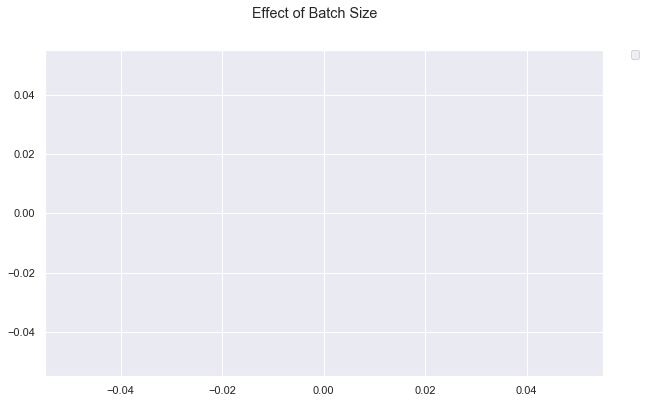

In [23]:
fig = plt.figure(figsize=(10,6))
fig.suptitle('Effect of Batch Size')
sns.set()
for w in [0,5]:
    for i in [6]:
        validation = []
        test = []
        for j in [128,256, 512]:
            rec = records.filter(lambda r: r['args']['test_envs'] == [w]  
                                and r['hparams']['batch_size']==j
                                and r['hparams']['fd']==i*10
                                and r['hparams']['n_comp']==i).map(selection_method._step_acc)
            if len(rec):
                m = rec.argmax('val_acc')
                print('%d env, %d fd' % (i,j))
                print(m)
                validation.append(m['val_acc'])
                test.append(m['test_acc'])
            else: 
                validation.append(None)
                test.append(None)
        sns.lineplot([128,256, 512], validation, marker='o', label='env%d_fd%d_val' % (w,i))
        sns.lineplot([128,256, 512], test, marker='o', label='env%d_fd%d_test' % (w,i))
plt.legend(bbox_to_anchor=(1.05,1), loc=2, borderaxespad=0)

1500
0.9692000831479834
0.8755338621110433
3600
0.9717417198919162
0.863941427699817
1200
0.97060297174718
0.8340451494813911
3300
0.9686168356846109
0.8926174496644296


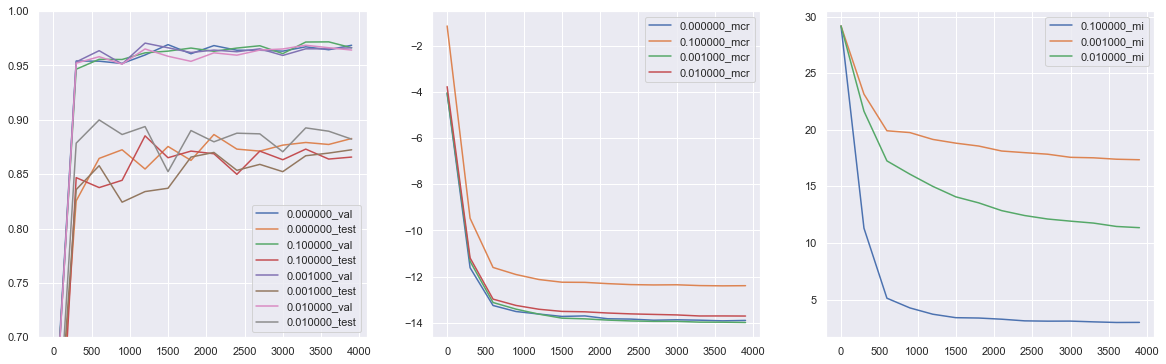

In [55]:
f, axes = plt.subplots(1,3,figsize=(20,6))
sns.set()
for i in [0, 0.1, 0.001, 0.01]:
    validation = []
    test = []
    ce = []
    mi = []
    mm = 0
    tm = 0
    amax = 0
    for j in range(0,4000,300):
        rec = records.filter(lambda r: r['hparams']['beta']==i
                            and r['step']==j)
        if len(rec):
            m = rec.map(selection_method._step_acc).argmax('val_acc')
            validation.append(m['val_acc'])
            if mm <= m['val_acc']:
                mm = m['val_acc']
                tm = m['test_acc']
                amax = j
            test.append(m['test_acc'])
            ce.append(rec[0]['mcr'])
            m = rec[0]['mi']
            if m and i != 0:
                mi.append(rec[0]['mi']/i)
            else:
                mi.append(rec[0]['mi'])
        else:
            mi.append(None)
            ce.append(None)
            validation.append(None)
            test.append(None)
    print(amax)
    print(mm)
    print(tm)
    a = sns.lineplot(range(0,4000,300), validation, label='%f_val' % i, ax=axes[0])
    a.set(ylim=(0.7,1))
    b = sns.lineplot(range(0,4000,300), test, label='%f_test' % i, ax=axes[0])
    b.set(ylim=(0.7,1))
    c = sns.lineplot(range(0,4000,300), ce, label='%f_mcr' % i, ax=axes[1])
    if i is not 0:
        d = sns.lineplot(range(0,4000,300), mi, label='%f_mi' % i, ax=axes[2])


In [88]:
m_s = np.load('output/mcr/256_60_e0/singular.npy', allow_pickle=True)
m_c = np.load('output/mcr/256_60_e0/components.npy', allow_pickle=True)
e_s = np.load('output/erm/256_60_e0/singular.npy', allow_pickle=True)
e_c = np.load('output/erm/256_60_e0/components.npy', allow_pickle=True)

In [110]:
def plot_heatmap(a):
    """Plot heatmap of cosine simliarity for all features. """
    plt.rc('text', usetex=False)
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman'] #+ plt.rcParams['font.serif']

    fig, ax = plt.subplots(figsize=(7, 5), sharey=True, sharex=True, dpi=400)
    im = ax.imshow(a, cmap='Blues')
    fig.colorbar(im, pad=0.02, drawedges=0, ticks=[0, 0.5, 1])
    ax.set_xticks(np.linspace(0, a.shape[0], 6))
    ax.set_yticks(np.linspace(0, a.shape[0], 6))
    [tick.label.set_fontsize(10) for tick in ax.xaxis.get_major_ticks()] 
    [tick.label.set_fontsize(10) for tick in ax.yaxis.get_major_ticks()]
    fig.tight_layout()

In [ ]:
a = torch.cat([m_c.item().get(i) for i in range(10)]).numpy()
print(a.shape)
plot_heatmap(a@a.T)

In [ ]:
print(m_c.item().get(1))

In [ ]:
a = torch.cat([e_c.item().get(i) for i in range(10)]).numpy()
print(a.shape)
plot_heatmap(a@a.T)

In [118]:
m_if = np.load('output/mcr/256_60_e0/incorrect_features.npy', allow_pickle=True)
m_il = np.load('output/mcr/256_60_e0/incorrect_labels.npy', allow_pickle=True)
e_if = np.load('output/erm/256_60_e0/incorrect_features.npy', allow_pickle=True)
e_il = np.load('output/erm/256_60_e0/incorrect_labels.npy', allow_pickle=True)


In [125]:
print(m_if[0][0])

[[[0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
  